In [1]:
import qctoolkit as qtk
import numpy as np
from glob import glob
from datetime import datetime
import os
import sys
from matplotlib import pyplot as plt
from copy import deepcopy
from IPython.display import display, HTML, SVG
import pandas as pd

import xml.etree.ElementTree as ET
import re
import svgutils.compose as sc

%matplotlib inline

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mol_name = 'coronene'
mol_base = qtk.Molecule(mol_name + '.xyz')

mol_data = np.load('data_' + mol_name + '.npz')
d1E_data = np.load('data_' + mol_name + '_1st.npz')
ev_data = mol_data['v']
ew_data = mol_data['w']
d1E_Z = d1E_data['arr_0']
N_heavy = int(np.ones(mol_base.N)[mol_base.Z > 1].sum())

qtk.setting.quiet=True
ccs_BN = [qtk.CCS(mol_base, yml) for yml in sorted(glob('ccs/coronene_BN*.yml'))]
qtk.setting.quiet=False

In [3]:
# atomization energy data

A_ref = {
    'C': -37.78852730974084,
    'B': -23.78911314264996,
    'N': -53.48097646532363,
    'H': -0.4986274134174679,
}
E_atoms = [12 * A_ref['H'] + (24 - 2*i) * A_ref['C'] + i * (A_ref['B'] + A_ref['N']) 
           for i in range(1, 13)]

E_nn_ref = 1820.34201982
E_tot_ref = -920.8066353108413
E_ref = E_tot_ref - E_nn_ref

In [4]:
def energy_estimate(dZ):
    # normal mode decomposition
    dZes = dZ.dot(ev_data)
    # calculate first/second order estimate
    d1E = dZ.dot(d1E_Z)
    d2E = (dZes ** 2).dot(ew_data) * 0.5
    return d1E + d2E

def penalty_function(ccs_coord, ccs, name, qmsetting_dict={}):

    time_stamp = datetime.now()

    mol_mut = ccs.generate(**ccs_coord)
    mol_mut.name = '%s_%s' % (name, time_stamp.strftime('%m%d%H%M%S%f')[:11])
    mol_mut.name = mol_mut.name + '_' + str(os.getpid())[-3:]
    
    # construct vector of dZ, lenght of 24 for coronene
    mol_mut_dZ = mol_mut.Z[:N_heavy] - mol_base.Z[:N_heavy]
    D2E = energy_estimate(mol_mut_dZ)
    
    return D2E, mol_mut.name

def penalty_function_AE(ccs_coord, ccs, name, qmsetting_dict={}):
    D2E, name = penalty_function(ccs_coord, ccs, name, qmsetting_dict={})
    mol_mut = ccs.generate(**ccs_coord)
    mol_mut.name = name
    
    E = E_ref + D2E + mol_mut.nuclear_repulsion()
    ind = len(mol_mut.Z[mol_mut.Z == 5]) - 1
    E_atom = E_atoms[ind]
    
    return E - E_atom, mol_mut.name

In [5]:
ccs = ccs_BN[3]
coord_test = ccs.random()[1]
print penalty_function(coord_test, ccs, 'test')
print penalty_function_AE(coord_test, ccs, 'test')
mol_test = ccs.generate(**coord_test)
print mol_test.Z

(-5.70104291618941, 'test_08311131155_435')
(-7.383613962133268, 'test_08311131155_435')
[6. 6. 6. 6. 5. 6. 7. 6. 6. 7. 7. 5. 6. 6. 6. 6. 5. 6. 6. 7. 6. 6. 6. 5.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
ccs = ccs_BN[-1]
crd1 = ccs.random()[1]
crd2 = ccs.random()[1]
#print crd1['mutation'], crd2['mutation']
Z = np.array(ccs.mate(crd1, crd2, 0.05)['mutation'][0])
print len(Z[Z == 5])

12


In [6]:
test_dz = np.loadtxt('../02_ANM_modePlot/data_space/coronene-dz-02-data.txt')
test_dE = np.loadtxt('../02_ANM_modePlot/data_space/coronene-dE-02-data.txt')
energy_estimate(test_dz) - test_dE[:,0]

array([ 6.37268016e-14, -3.62672199e-06, -4.99993313e-09,  1.06418402e-05,
       -3.55271368e-15,  1.07247544e-13,  6.70574707e-14,  4.19664303e-14,
        1.71418435e-13, -1.01454849e-05,  4.24793137e-06, -1.01504848e-05,
       -4.24793131e-06,  5.89755342e-06, -5.90255340e-06, -4.24793141e-06,
       -4.24793133e-06])

In [7]:
def get_optimizer(ccs, mode, name=None, max_step=10000):
    if name is None:
        name = os.path.splitext(ccs.__repr__().replace(' ','_'))[0]
    log_file = '%s.db' % name
    ccs_copy = deepcopy(ccs)
    penalty_input = deepcopy([ccs_copy, name, {}])
    optimizer = qtk.optimization.GeneticOptimizer(
        #penalty_function_AE,
        penalty_function,
        penalty_input,
        ccs.random_coord,#genCCSInp,
        ccs.mate,
        20,
        log_file=log_file,
        new_run=False,
        max_step=max_step,
        mode=mode,
    )
    return optimizer

In [59]:
test_optimzer = get_optimizer(ccs_BN[-1], 'maximize', 'test', max_step=5000)

In [60]:
test_optimzer.run()

remove old log file
DB: creating database: test.db 
GA: 0 steps 
yo Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[5.0, 5.0, 7.0, 7.0, 7.0, 7.0, 7.0, 5.0, 5.0, 5.0, 7.0, 5.0, 5.0, 7.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0, 7.0, 5.0, 5.0, 7.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-18.77124320504786, 'test_02141016069_026') 
yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo GA: 100 steps 
yo Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[5.0, 5.0, 7.0, 5.0, 5.0, 5.0, 7.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0, 5.0, 7.0, 5.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 5.0, 7.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-2.

yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo GA: 1100 steps 
yo Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[5.0, 7.0, 5.0, 5.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0, 7.0, 5.0, 7.0, 5.0, 7.0, 7.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0, 5.0, 7.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-11.754300911441643, 'test_02141017095_026') 
yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo G

DB: attempt to commit... 
DB: done 
evaluate: current result (-19.829581299698066, 'test_02141018229_026') 
yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo GA: 2200 steps 
yo something wrong during optimization, closing session...
GA: 2200 steps 
yo Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[7.0, 5.0, 5.0, 7.0, 5.0, 7.0, 7.0, 5.0, 7.0, 5.0, 7.0, 5.0, 7.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-16.878857358550633, 'test_02141018313_026') 
yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo y

DB: adding entry {'mutation': [[5.0, 5.0, 7.0, 5.0, 5.0, 5.0, 7.0, 5.0, 7.0, 7.0, 7.0, 7.0, 5.0, 5.0, 7.0, 5.0, 5.0, 7.0, 7.0, 5.0, 7.0, 7.0, 5.0, 7.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-11.432819979384014, 'test_02141020114_026') 
yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo yo GA: 3300 steps 
yo Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[7.0, 5.0, 7.0, 7.0, 5.0, 7.0, 5.0, 7.0, 5.0, 5.0, 7.0, 7.0, 7.0, 5.0, 5.0, 7.0, 5.0, 7.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-21.773616110954478, 'test_02141020228_026') 
yo yo yo yo yo yo yo yo yo yo 

In [8]:
test_log = qtk.Logger('test.db')

DB: loading existing database: test.db 


In [9]:
qtk.setting.quiet=False
ccs.report()

 ===== CCS REPORT ===== 
generating molecule: coronene 
ccs parameter file: ccs/coronene_BN04.yml 
mutation indices: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]] 
target atomic numbers: [[5, 6, 7]] 
length of mutation vector: 24 <=> [24] 
Z_sum: 156 
element_count: {'B': [4], 'N': [4]} 
ccs coordinate: ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'] 
 ========= END ======== 


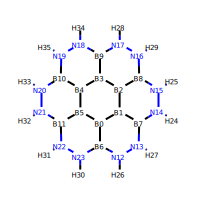

In [10]:
mol = ccs.get_molecule(test_log.list(order='descent')[0].content)
mol.view2D()

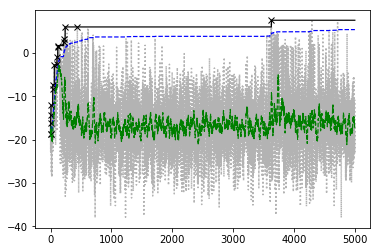

In [70]:
qtk.analysis.ga_hist_plot(test_log.list(),mode=max,moving_avg=True)

In [12]:
a = np.array([[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0, 7.0, 7.0, 7.0, 5.0, 5.0, 7.0, 7.0, 7.0, 5.0, 7.0, 7.0, 7.0]])

In [11]:
optimizers = []
max_step = 1000
for ccs in ccs_BN:
    name = os.path.splitext(ccs.parameter_file)[0].split('_')[-1]
    opt = get_optimizer(ccs, 'minimize', name+'_min_local', max_step=max_step)
    optimizers.append(opt)
    #opt.run()
    opt = get_optimizer(ccs, 'maximize', name+'_max_local', max_step=max_step)
    optimizers.append(opt)
    #opt.run()

# local runs

In [ ]:
optimizers[-1].run()

GA: 0 steps 
Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[5.0, 7.0, 7.0, 7.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0, 7.0, 7.0, 5.0, 7.0, 7.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 5.0, 7.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-26.097092160287616, 'BN12_max_local_02131756437_679') 
GA: 100 steps 
Optimizer: GE iteration with 1 new points 
DB: adding entry {'mutation': [[7.0, 5.0, 5.0, 5.0, 7.0, 5.0, 5.0, 7.0, 5.0, 7.0, 5.0, 7.0, 7.0, 7.0, 7.0, 5.0, 7.0, 7.0, 7.0, 5.0, 5.0, 5.0, 7.0, 5.0]]} None processing (x270) 
DB: attempt to commit... 
DB: done 
evaluate: current result (-11.337075740748297, 'BN12_max_local_02131759070_679') 


# Parallelize 
optimization object can not be parsed to python subprocess. Therefore it can not be parallelized within python

In [135]:
try:
    ind = int(sys.argv[1])
    assert 0 <= ind < 24
    try:
        ptimizers[ind].run()
    except Exception as err:
        print str(err)
except Exception as err:
    print "command line arg 0-23, err: %s" % str(err)

command line arg 0-23, err: invalid literal for int() with base 10: '-f'


# Analysis

In [12]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pandas as pd

%matplotlib inline

In [13]:
root_dir = 'results_redo'
#root_dir = 'results'

qtk.setting.quiet = True
log_min = []
for f in sorted(glob('%s/BN[01][0-9]_min.db' % root_dir)):
    log_min.append(qtk.Logger(f))
    
log_max = []
for f in sorted(glob('%s/BN[01][0-9]_max.db' % root_dir)):
    log_max.append(qtk.Logger(f))
    
qtk.setting.quiet = False

In [14]:
def set_ax(outs, legend=True, ylabel=True, xlabel=True, loc=None):
    ax = outs[0]
    hist = outs[1][0]
    best = outs[2][0]
    #test.set_color('r')
    hist.set_label('history')
    best.set_linewidth(2)
    ymin, ymax = ax.get_ylim()
    #ax.vlines(e.id, ymin=ymin, ymax=ymax)
    #ax.set_yscale("log")
    #ax.set_title(str(opt))
    if legend:
        ax.legend(fontsize=15, loc=loc)
    ax.set_xlim(0,N)
    if ylabel:
        ax.set_ylabel(r'$\Delta E_{\rm ele}$ [a.u.]', fontsize=15)
    if xlabel:
        ax.set_xlabel(r'$s$', fontsize=15)

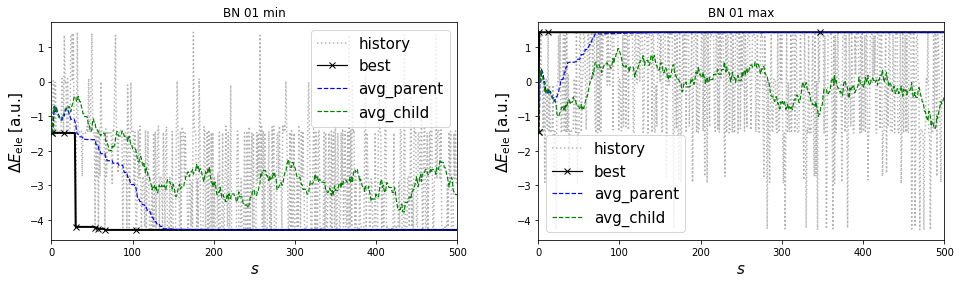

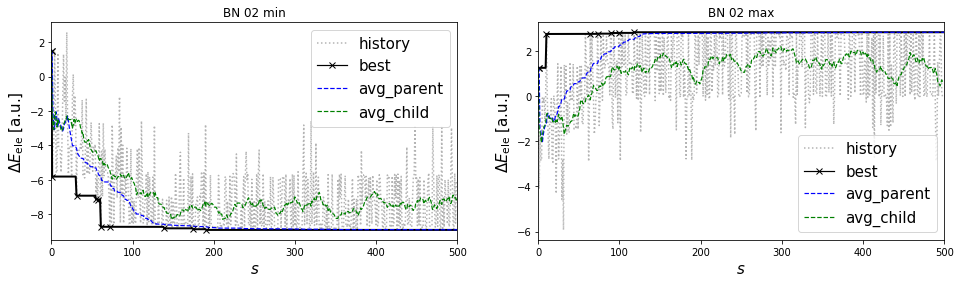

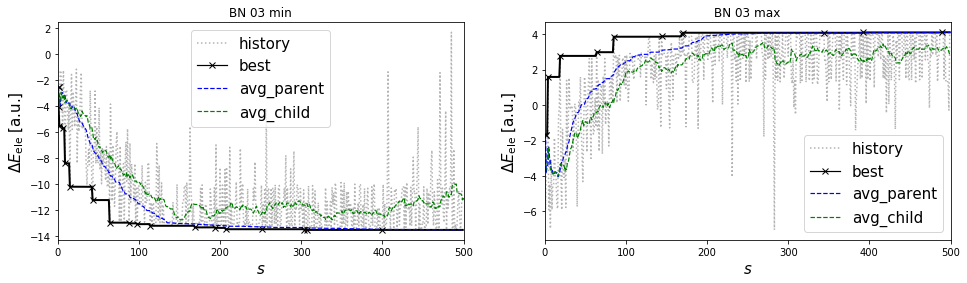

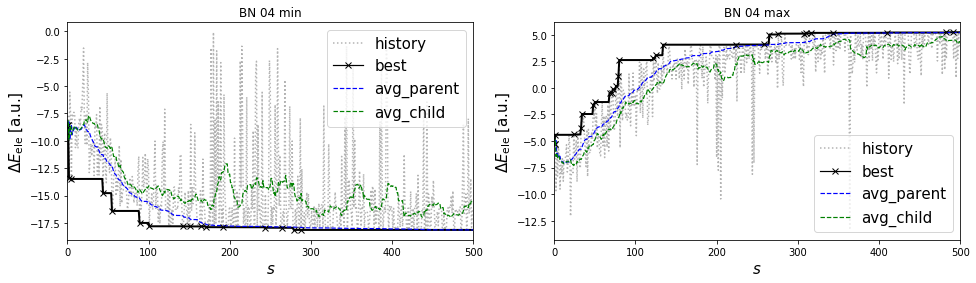

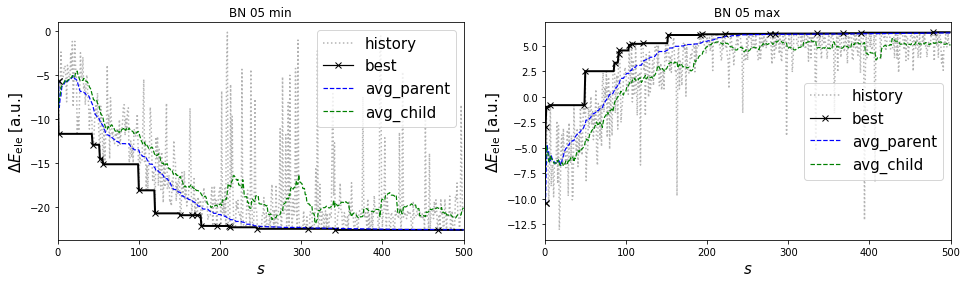

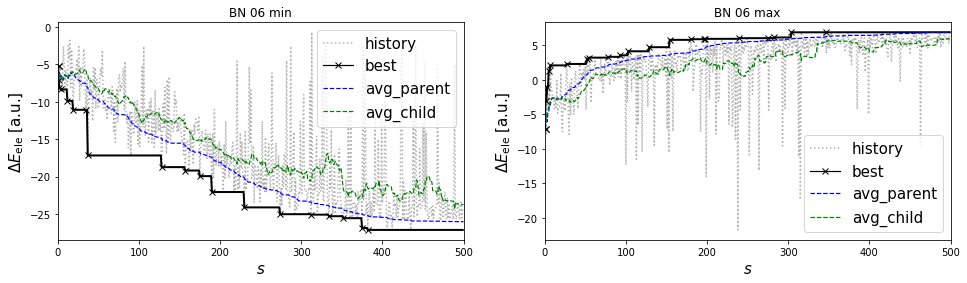

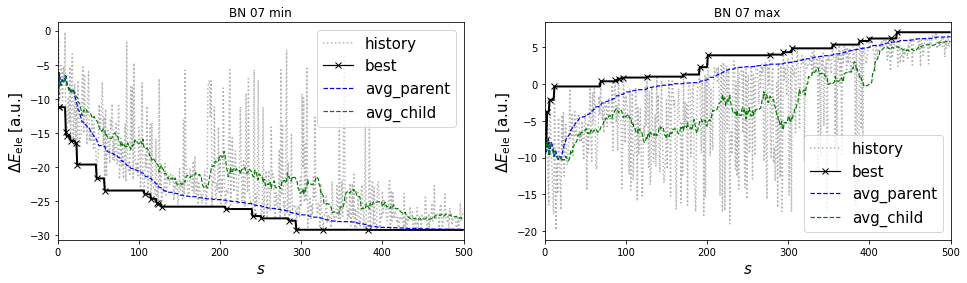

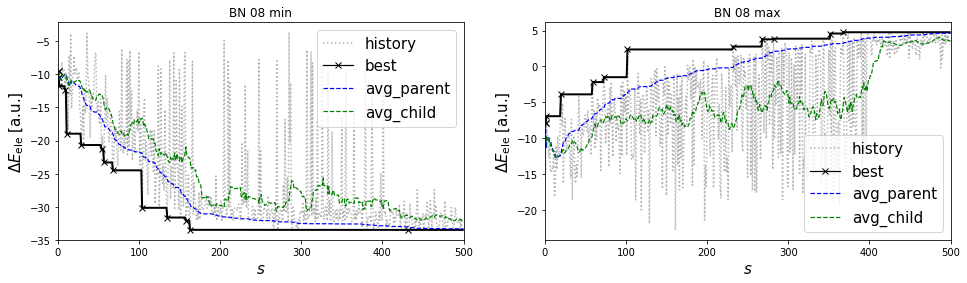

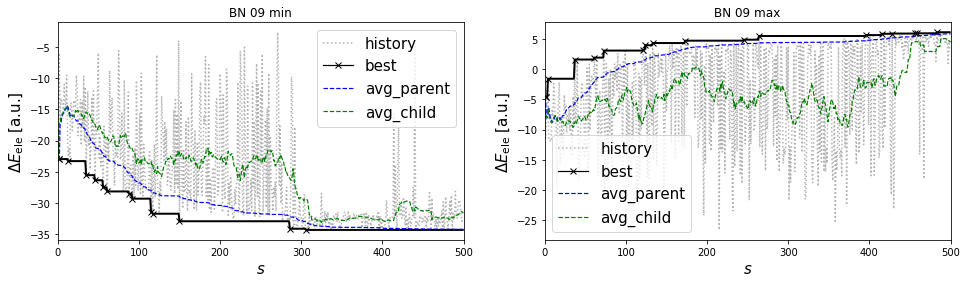

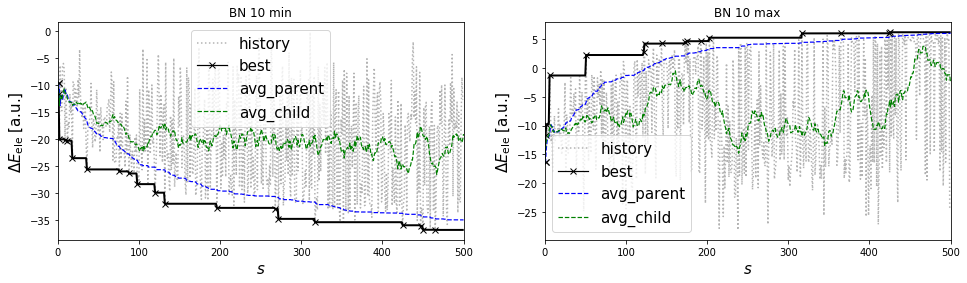

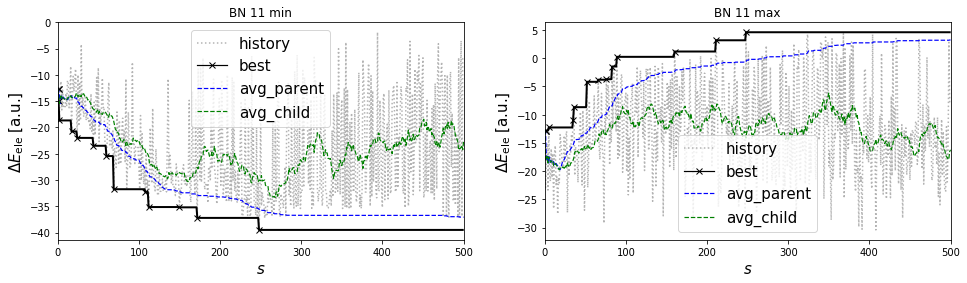

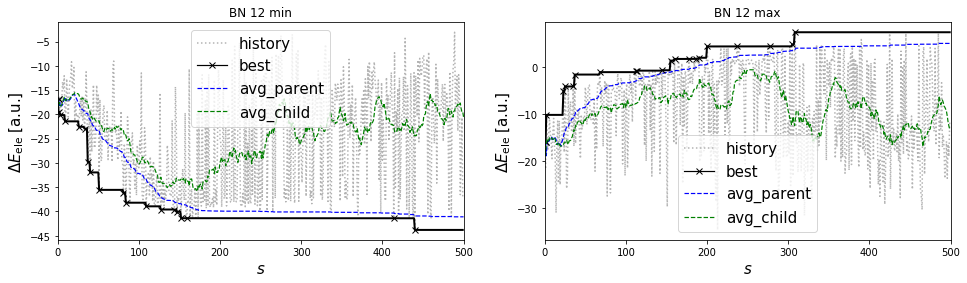

In [15]:
N = 500
N_sys = 12

for ind in range(N_sys):

    fig = plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    outs1 = qtk.analysis.ga_hist_plot(
        log_min[ind].list()[:N], mode=min, moving_avg=True, ax=ax1, get_results=True)
    set_ax(outs1)
    outs2 = qtk.analysis.ga_hist_plot(
        log_max[ind].list()[:N], mode=max, moving_avg=True, ax=ax2, get_results=True)
    set_ax(outs2)
    
    ax1.set_title('BN %02d min' % (ind+1))
    ax2.set_title('BN %02d max' % (ind+1))

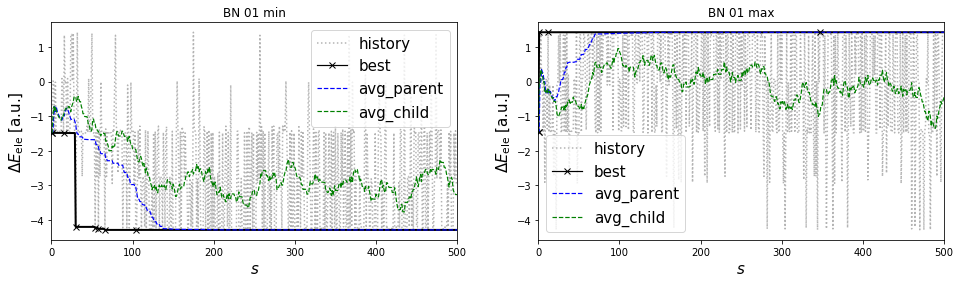

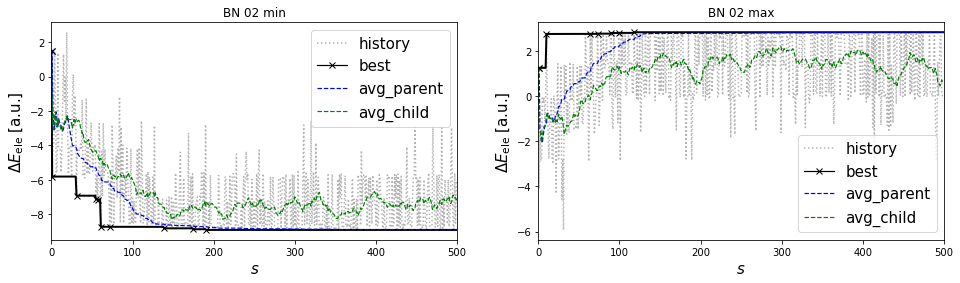

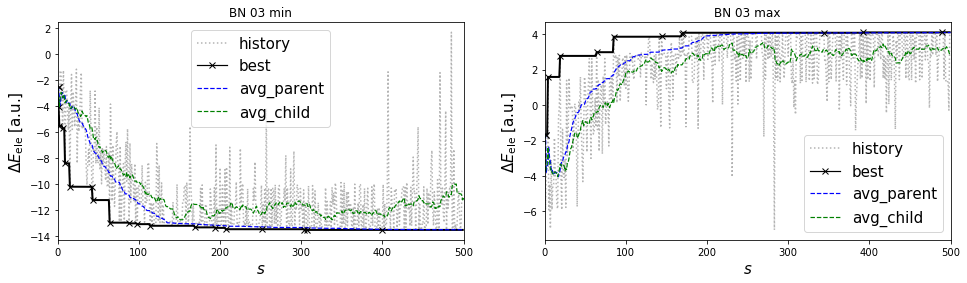

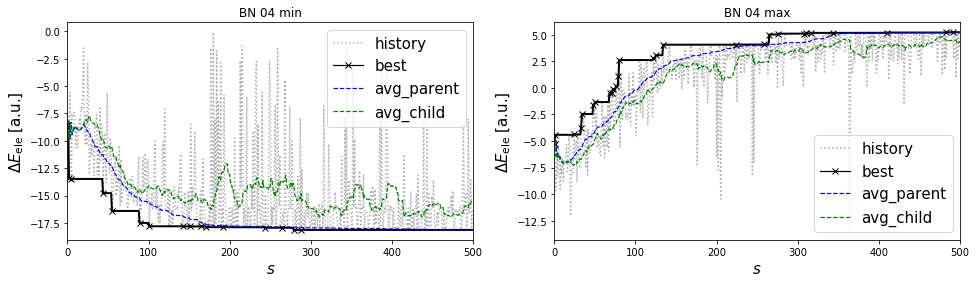

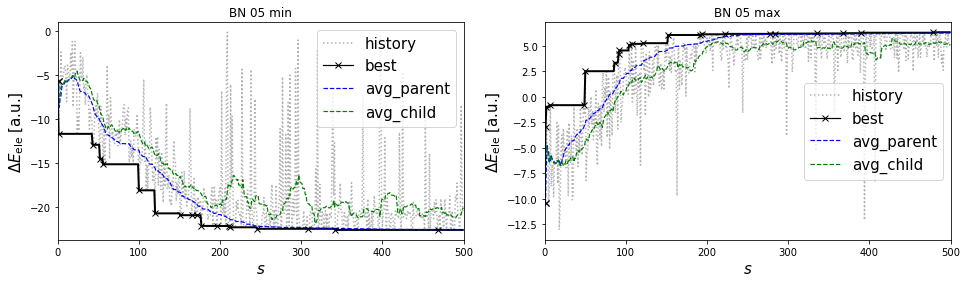

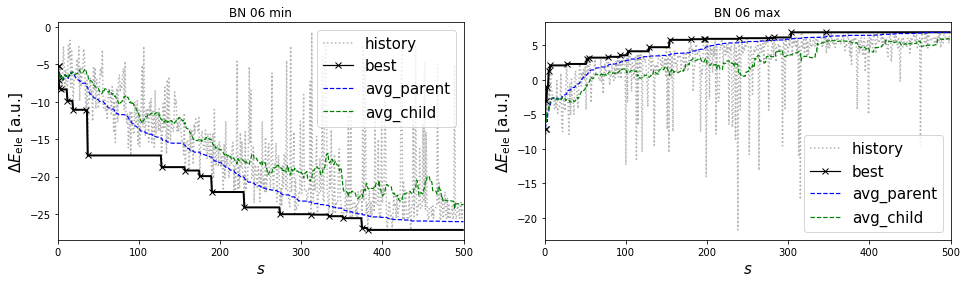

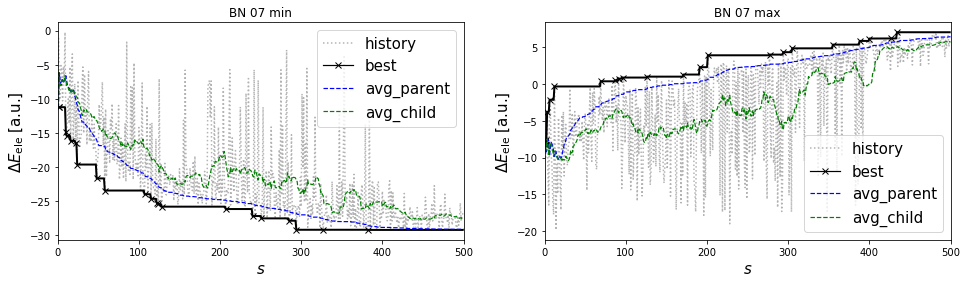

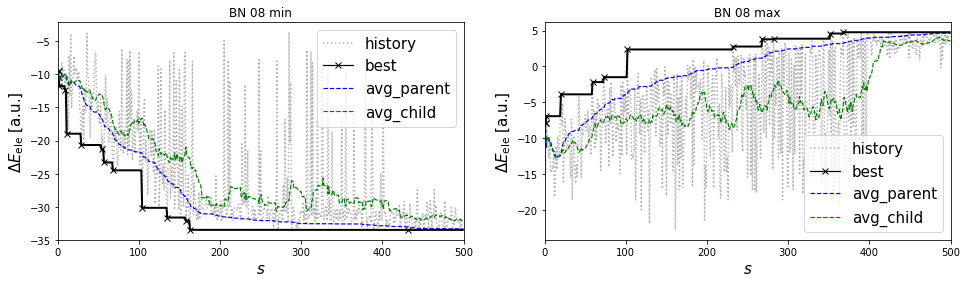

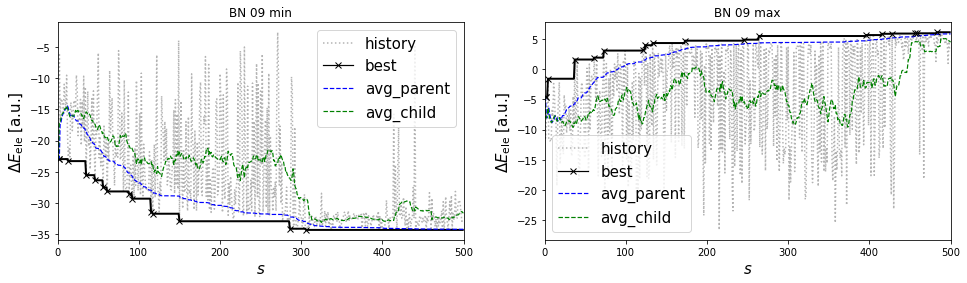

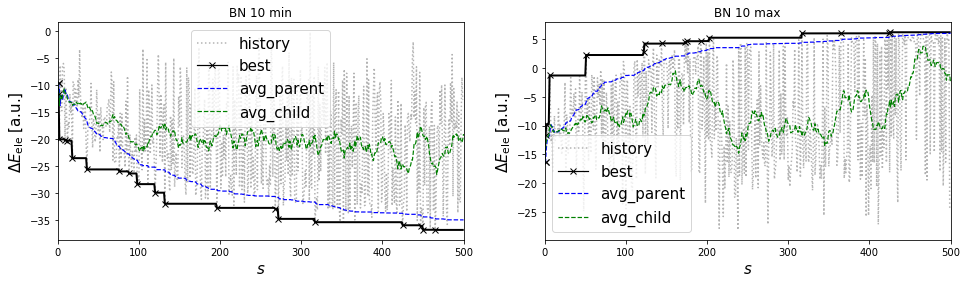

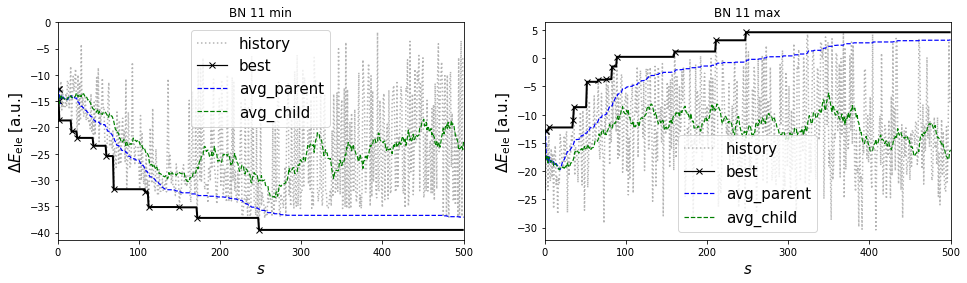

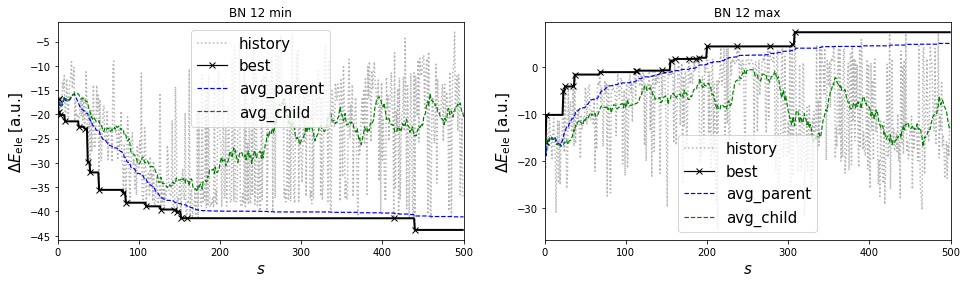

In [74]:
N = 500
N_sys = 12

for ind in range(N_sys):

    fig = plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    outs1 = qtk.analysis.ga_hist_plot(
        log_min[ind].list()[:N], mode=min, moving_avg=True, ax=ax1, get_results=True)
    set_ax(outs1)
    outs2 = qtk.analysis.ga_hist_plot(
        log_max[ind].list()[:N], mode=max, moving_avg=True, ax=ax2, get_results=True)
    set_ax(outs2)
    
    ax1.set_title('BN %02d min' % (ind+1))
    ax2.set_title('BN %02d max' % (ind+1))

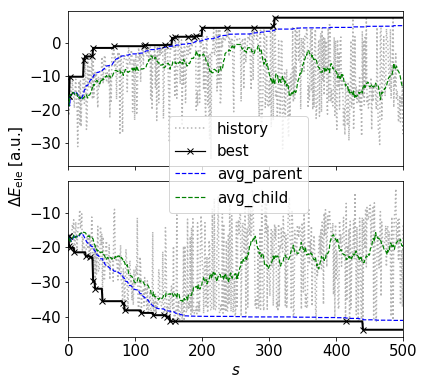

In [16]:
def minmax_plot(ind=-1, N=700, axarr=None, figpath=None, figsize=(6,6), loc=(.3,-.3)):
    
    if axarr is None:
        fig, axarr = plt.subplots(2, 1, figsize=figsize, sharex=True)

    ax2, ax1 = axarr

    outs1 = qtk.analysis.ga_hist_plot(
        log_min[ind].list()[:N], mode=min, moving_avg=True, ax=ax1, get_results=True)
    set_ax(outs1, legend=False, ylabel=False)
    outs2 = qtk.analysis.ga_hist_plot(
        log_max[ind].list()[:N], mode=max, moving_avg=True, ax=ax2, get_results=True)
    set_ax(outs2, ylabel=False, xlabel=False, loc=loc)
    ax2.set_zorder(10)

    ax1.set_ylabel(r'$\Delta E_{\rm ele}$ [a.u.]', y=1.1, fontsize=15)

    ax1.tick_params(axis='both', labelsize=15)
    ax2.tick_params(axis='both', labelsize=15)

    fig.subplots_adjust(hspace=0.1)
    
    if figpath is not None:
        fig.savefig(figpath, transparent=True)

minmax_plot()

In [17]:
BN_min = [log.list(order='ascent')[0].data for log in log_min[:N_sys]]
BN_max = [log.list(order='descent')[0].data for log in log_max[:N_sys]]

In [19]:
BN_min

[-4.28543317304,
 -8.92078343439,
 -13.5354085529,
 -18.1373137622,
 -22.5946128773,
 -27.1367582999,
 -29.2363678599,
 -33.4843149775,
 -34.3147321717,
 -37.7179177648,
 -40.1144407622,
 -43.8074153848]

In [18]:
# adding nuclear repulsion will give different ordering

BN_min_atom = [
    log.list(order='ascent')[0].data + E_ref - E_atoms[i] \
    + ccs_BN[i/2].get_molecule(log.list(order='ascent')[0].content).nuclear_repulsion()
    for i, log in enumerate(log_min[:N_sys])
]
BN_max_atom = [
    log.list(order='descent')[0].data + E_ref - E_atoms[i] \
    + ccs_BN[i/2].get_molecule(log.list(order='descent')[0].content).nuclear_repulsion()
    for i, log in enumerate(log_max[:N_sys])
]

In [98]:
E_min_sym = [-1.48541224,
 -3.36804485,
 -5.49439855,
 -7.6589273,
 -9.72446587,
 -11.98142912,
 -14.08759125,
 -16.2662202,
 -18.44054357,
 -19.9676277,
 -22.25619032,
 -24.33137273]

E_max_sym = [-1.2848788,
 -2.48968729,
 -3.66216402,
 -4.92987684,
 -6.13428798,
 -7.38197634,
 -8.59909973,
 -9.78877304,
 -10.99001376,
 -12.25604751,
 -13.47386536,
 -14.74154955]

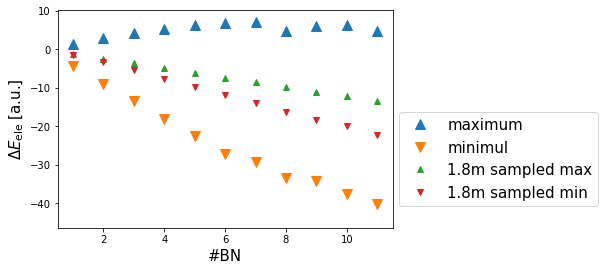

In [99]:
x = range(1, len(BN_min) + 1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, BN_max, ls='', marker='^', ms=10, label='maximum')
ax.plot(x, BN_min, ls='', marker='v', ms=10, label='minimul')
ax.plot(x, E_max_sym, ls='', marker='^', label='1.8m sampled max')
ax.plot(x, E_min_sym, ls='', marker='v', label='1.8m sampled min')

ax.set_xlabel('#BN', fontsize=15)
ax.set_ylabel(r'$\Delta E_{\rm ele}$ [a.u.]', fontsize=15)
ax.set_xlim([0.5,11.5])
ax.legend(fontsize=15, loc=(1.02, 0.1))

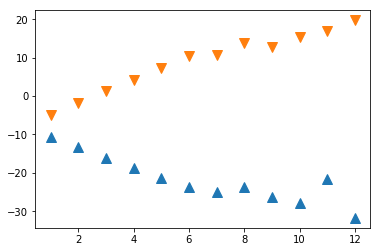

In [100]:
plt.plot(x, BN_max_atom, ls='', marker='^', ms=10)
plt.plot(x, BN_min_atom, ls='', marker='v', ms=10)

In [27]:
mol_max = [ccs_BN[i/2].get_molecule(log.list(order='descent')[0].content) for i, log in enumerate(log_max[:N_sys])]
mol_min = [ccs_BN[i/2].get_molecule(log.list(order='ascent')[0].content) for i, log in enumerate(log_min[:N_sys])]

In [28]:
def highlight(mol):
    return np.arange(mol.N)[(mol.Z == 5) | (mol.Z == 7)].tolist()

def colors(mol):
    color = {}
    for ind in highlight(mol):
        if mol.Z[ind] == 5:
            color[ind] = tuple([1,0,0])
        elif mol.Z[ind] == 7:
            color[ind] = tuple([0,0,1])
    return color

def mol2dZ(mol):
    dZ = mol.Z[mol.Z > 1]
    dZ = dZ - np.ones(len(dZ)) * 6
    return dZ

def estimate_mol(mol):
    return energy_estimate(mol2dZ(mol))

In [36]:
setting = dict(
    figSize=(300,300), 
    remove_H=True, 
    index=False, 
    atom_label=False   
)

no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'

for mol in [mol_max[-1], mol_min[-1]]:
    svg = qtk.rdk.mol2svg(mol_base, highlight=highlight(mol), colors=colors(mol), **setting)

    print 'dE = %.10f [Ha]' % estimate_mol(mol)
    display(HTML(svg))
    
mol_max[-1].write("/home/samio/Desktop/opt_max.xyz")
mol_min[-1].write("/home/samio/Desktop/opt_min.xyz")

dE = 7.5100177648 [Ha]


dE = -43.8074153848 [Ha]


In [29]:
setting = dict(
    figSize=(300,300), 
    remove_H=True, 
    index=False, 
    atom_label=False   
)

no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'

svg_min = []
svg_max = []
for i, (mol1, mol2) in enumerate(zip(mol_max, mol_min)):
    print 'from opt:',
    print BN_max[i], BN_min[i]
    print 'from eig:', 
    print estimate_mol(mol1), estimate_mol(mol2)
    svg1 = qtk.rdk.mol2svg(mol_base, highlight=highlight(mol1), colors=colors(mol1), **setting)
    svg2 = qtk.rdk.mol2svg(mol_base, highlight=highlight(mol2), colors=colors(mol2), **setting)
    svg_max.append(svg1)
    svg_min.append(svg2)
    display(HTML(no_wrap_div.format(svg1, svg2)))

from opt: 1.42745996804 -4.28543317304
from eig: 1.4274599680420388 -4.285433173042169


from opt: 2.81495007815 -8.92078343439
from eig: 2.8149500781525907 -8.920783434389882


from opt: 4.11944219243 -13.5354085529
from eig: 4.119442192431871 -13.535408552916778


from opt: 5.27271523464 -18.1373137622
from eig: 5.272715234642622 -18.137313762195834


from opt: 6.34717540475 -22.5946128773
from eig: 6.347175404753273 -22.59461287730647


from opt: 6.87991624438 -27.1367582999
from eig: 6.879916244378945 -27.136758299863708


from opt: 7.0461415699 -29.2363678599
from eig: 7.046141569896857 -29.236367859863606


from opt: 4.77373522986 -33.4843149775
from eig: 4.773735229863835 -33.4843149774833


from opt: 6.08001361932 -34.3147321717
from eig: 6.080013619323632 -34.31473217173696


from opt: 6.15752191984 -37.7179177648
from eig: 6.157521919841603 -37.71791776484157


from opt: 4.66627296858 -40.1144407622
from eig: 4.666272968577395 -40.11444076219968


from opt: 7.51001776482 -43.8074153848
from eig: 7.510017764819441 -43.80741538481945


In [104]:
def svg2file(svgs, name, root):
    if not os.path.exists(root):
        os.makedirs(root)
    for i, s in enumerate(svgs):
        with open('%s/BN_%02d_%s.svg' % (root, i+1, name), 'w') as f:
            f.write(s)

In [105]:
svg2file(svg_min, 'min', 'BN_min_ele_redo')
svg2file(svg_max, 'max', 'BN_max_ele_redo')

In [106]:
def dataBN2df(name, E_list, mol_list):
    df = pd.DataFrame()
    df['fig_name'] = ['BN_%02d_%s.svg' % (i+1, name) for i in range(12)]
    df['num_BN'] = range(1, 13)
    df['E_ele'] = E_list
    df['dZ'] = [np.array(mol2dZ(mol)).astype(int) for mol in mol_list]
    df['nuclear_repulsion'] = [np.round(mol.nuclear_repulsion(), decimals=3) for mol in mol_list]
    df.set_index('fig_name', inplace=True)
    return df

In [107]:
df_min = dataBN2df('min', BN_min, mol_min)
df_max = dataBN2df('max', BN_max, mol_max)

In [108]:
df_min

num_BN      E_ele  \
fig_name                           
BN_01_min.svg       1  -4.285433   
BN_02_min.svg       2  -8.920783   
BN_03_min.svg       3 -13.535409   
BN_04_min.svg       4 -18.137314   
BN_05_min.svg       5 -22.594613   
BN_06_min.svg       6 -27.136758   
BN_07_min.svg       7 -29.236368   
BN_08_min.svg       8 -33.484315   
BN_09_min.svg       9 -34.314732   
BN_10_min.svg      10 -37.717918   
BN_11_min.svg      11 -40.114441   
BN_12_min.svg      12 -43.807415   

                                                              dZ  \
fig_name                                                           
BN_01_min.svg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
BN_02_min.svg  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0...   
BN_03_min.svg  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
BN_04_min.svg  [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -...   
BN_05_min.svg  [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1...   
BN_06_min.svg  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -...   
BN_07_min.svg  [1, 1, 1, 1, 1, 1, 0, -1, 0, 0, 1, 0, -1, -1, ...   
BN_08_min.svg  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, -1, -1, -...   
BN_09_min.svg  [1, 1, 1, 1, 1, 1, 1, -1, -1, 0, 1, 1, -1, -1,...   
BN_10_min.svg  [1, 1, 1, 1, 1, 1, 1, 1, -1, 0, 1, 1, -1, -1, ...   
BN_11_min.svg  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, ...   
BN_12_min.svg  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -...   

               nuclear_repulsion  
fig_name                          
BN_01_min.svg           1825.876  
BN_02_min.svg           1831.942  
BN_03_min.svg           1837.909  
BN_04_min.svg           1843.923  
BN_05_min.svg           1849.658  
BN_06_min.svg           1855.607  
BN_07_min.svg           1856.356  
BN_08_min.svg           1861.973  
BN_09_min.svg           1860.014  
BN_10_min.svg           1864.468  
BN_11_min.svg           1866.629  
BN_12_min.svg           1871.479

In [109]:
df_max

num_BN     E_ele  \
fig_name                          
BN_01_max.svg       1  1.427460   
BN_02_max.svg       2  2.814950   
BN_03_max.svg       3  4.119442   
BN_04_max.svg       4  5.272715   
BN_05_max.svg       5  6.347175   
BN_06_max.svg       6  6.879916   
BN_07_max.svg       7  7.046142   
BN_08_max.svg       8  4.773735   
BN_09_max.svg       9  6.080014   
BN_10_max.svg      10  6.157522   
BN_11_max.svg      11  4.666273   
BN_12_max.svg      12  7.510018   

                                                              dZ  \
fig_name                                                           
BN_01_max.svg  [0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
BN_02_max.svg  [0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
BN_03_max.svg  [0, -1, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, ...   
BN_04_max.svg  [-1, -1, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0,...   
BN_05_max.svg  [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0...   
BN_06_max.svg  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, ...   
BN_07_max.svg  [-1, -1, -1, -1, -1, -1, 0, -1, 0, 0, 0, 0, 1,...   
BN_08_max.svg  [-1, -1, -1, -1, -1, -1, 0, -1, -1, 0, 1, 1, 1...   
BN_09_max.svg  [-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, 1, ...   
BN_10_max.svg  [-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 1,...   
BN_11_max.svg  [-1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 1, 1, ...   
BN_12_max.svg  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   

               nuclear_repulsion  
fig_name                          
BN_01_max.svg           1814.502  
BN_02_max.svg           1808.709  
BN_03_max.svg           1803.000  
BN_04_max.svg           1797.554  
BN_05_max.svg           1792.201  
BN_06_max.svg           1787.626  
BN_07_max.svg           1784.420  
BN_08_max.svg           1786.324  
BN_09_max.svg           1780.608  
BN_10_max.svg           1777.430  
BN_11_max.svg           1783.420  
BN_12_max.svg           1768.695

In [111]:
df_min.to_csv('BN_ele/BN_min_ele/min_data.csv')
df_max.to_csv('BN_ele/BN_max_ele/max_data.csv')

# senity checks

In [20]:
def dZ2mol(dZ):
    crd = dict(
        mutation = [list(dZ + 6)]
    )
    mol = ccs_BN[0].get_molecule(crd)
    return mol

In [21]:
dZ01 = np.loadtxt('../02_ANM_modePlot/data_space/coronene-dz-02-data.txt')

In [22]:
mols_01 = []
for dZ in dZ01:
    mols_01.append(dZ2mol(dZ))

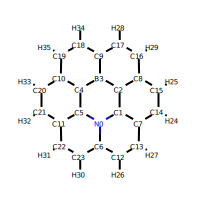

In [23]:
mols_01[0].view2D()

In [24]:
for m in mols_01:
    svg = qtk.rdk.mol2svg(mol_base, highlight=highlight(m), colors=colors(m), **setting)
    #svg = qtk.rdk.mol2svg(m)
    display(HTML(svg))

NameError: name 'highlight' is not defined

In [197]:
def canvas(s, dx, dy, atom_colors={}, costum_size=False):
    
    def shift(coord_str, length): return str(float(coord_str) + float(length))
    
    root = ET.fromstring(s)
    new_root = deepcopy(root)

    #####################
    # reset canvas size #
    #####################
    if costum_size:
        new_root.attrib['height'] = '100%'
        new_root.attrib['width'] = '100%'
    else:
        h = int(new_root.attrib['height'].split('p')[0]) + int(dy)
        w = int(new_root.attrib['width'].split('p')[0]) + int(dx)
        new_root.attrib['height'] = str(h) + 'px'
        new_root.attrib['width'] = str(w) + 'px'

    ################
    # move ellipse #
    ################
    # i.e. highlight circles 
    circles = new_root.findall('ellipse')
    for c in circles:
        c.attrib['cx']  = str(float(c.attrib['cx']) + dx / 2.)
        c.attrib['cy']  = str(float(c.attrib['cy']) + dy / 2.)

    ##############
    # move paths #
    ##############
    # i.e. connecting bonds
    paths = new_root.findall('path')
    for p in paths:

        start, end = p.attrib['d'].split(' ')[1:]

        s_x, s_y = start.split(',')
        e_x, e_y = end.split(',')

        s_x = shift(s_x, dx / 2.)
        s_y = shift(s_y, dy / 2.)
        e_x = shift(e_x, dx / 2.)
        e_y = shift(e_y, dy / 2.)

        start = ','.join([s_x, s_y])
        end = ','.join([e_x, e_y])
        new_d = 'M ' + ' '.join([start, end])

        p.attrib['d'] = new_d
        
    ##############
    # move texts #
    ##############
    texts = new_root.findall('text')
    for t in texts:
        t.attrib['x'] = str(float(t.attrib['x']) + dx / 2.)
        t.attrib['y'] = str(float(t.attrib['y']) + dy / 2.)
        text = t.getchildren()[0].text
        head = re.findall('[A-Z][^A-Z0-9]*', text)[0]
        if head in list(atom_colors.iterkeys()):
            rgb = atom_colors[head]
            html = rgb2html(rgb)
            style_str = t.attrib['style']
            style = style_str.split(';fill:')[0]
            t.attrib['style'] = style + ';fill:' + rgb2html(rgb)
            #t.getchildren()[0].text = 'test'
        
    ##########################
    # remove backgroun white #
    ##########################
    for child in new_root:
        if child.tag == "rect":
            new_root.remove(child)

    # convert to xml string
    return ET.tostring(new_root)

In [206]:
def svg_resize(s, width, height):
    root = ET.fromstring(s)
    new_root = deepcopy(root)
    new_root.attrib['height'] = str(height)
    new_root.attrib['width'] = str(width)
    # convert to xml string
    return ET.tostring(new_root)

In [200]:
display(HTML(canvas(svg, 10, 10)))

In [231]:
def mol2svg_cr(m):
    return qtk.rdk.mol2svg(mol_base, highlight=highlight(m), colors=colors(m), **setting)
    

def svg2file(svg, svg_path='mol_tmp.svg'):
    with open(svg_path, 'w') as f:
        f.write(svg)
    return svg_path

def mol2ScFile(m, dx=10, dy=10):
    mol_svg = canvas(mol2svg_cr(m),10,10)
    svg_file = svg2file(mol_svg)
    return svg_file

In [160]:
display(HTML(mol2svg_cr(mol_max[-1])))

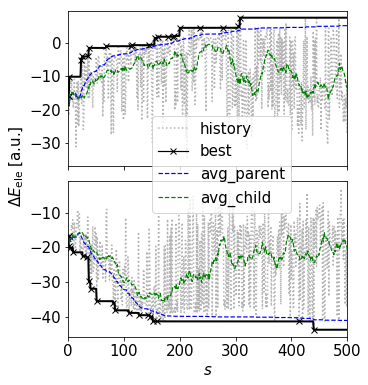

In [226]:
figpath = 'base.svg'
minmax_plot(figpath=figpath, figsize=(5,6))

In [232]:
svgs = [sc.Panel(sc.SVG(figpath).move(20,0))]

svgs.append(
    sc.Panel(
        sc.SVG(mol2ScFile(mol_min[-1])).scale(0.5).move(350,230)
    )
)

svgs.append(
    sc.Panel(
        sc.SVG(mol2ScFile(mol_max[-1])).scale(0.5).move(350,50)
    )
)

final_path = 'E_ele_opt.svg'

sc.Figure("8cm", "6cm",
    *svgs
    ).save(final_path)
pdf_path = os.path.splitext(final_path)[0] + '.pdf'


# command line inkscape to resize svg canvas
# inkscape command line reference:
# http://how-to.wikia.com/wiki/How_to_use_Inkscape_in_commandline_mode/List_of_verbs
os.system("inkscape %s --verb=FitCanvasToDrawing --verb=FileSave --verb=FileQuit" % final_path)

# convert svg to pdf
os.system("rsvg-convert -f pdf -o %s %s" % (pdf_path, final_path))
pass

SVG(final_path)